In [1]:
using JuMP
using Ipopt
using LinearAlgebra # For norm

## Setup Problem

In [90]:
# Problem parameters
state_dim = 8   # [x y z vx vy vz mass accumulated_control_effort]
control_dim = 3 # [ux uy uz]
horizon = 200
timestep = 1.0

# HCW parameters 
mean_motion = 0.001107
initial_mass = 100.0
isp = 10.0 
g0 = 9.80665 
nominal_radius = 50.0
u_max_abs = 1.0 
u_min_abs = -1.0 
u_max_norm_val = u_max_abs
u_min_norm_val = 0.0  

# Line-of-Sight Constraint Parameters ===
# Define the cone axis (must be a unit vector)
cone_axis = [1.0, 0.0, 0.0]
cone_axis = cone_axis / norm(cone_axis)

# Define the maximum cone half-angle (in degrees)
max_cone_angle_deg = 30.0
max_cone_angle_rad = deg2rad(max_cone_angle_deg)
cos_max_cone_angle = cos(max_cone_angle_rad)

# Epsilon for LOS regularization (for p_norm calculation)
epsilon_los = 1e-8

# Initial and goal states (goal_state mainly for initial guess interpolation)
initial_state = [nominal_radius, 0.0, 0.0, 0.0, -2.0*mean_motion*nominal_radius, 0.0, initial_mass, 0.0]
goal_state = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, initial_mass, 0.0];

## Define NLP

In [91]:

# Create JuMP model
model = Model(Ipopt.Optimizer)

# Solver options
set_optimizer_attribute(model, "max_iter", 1000)
set_optimizer_attribute(model, "print_level", 5) # Standard Ipopt print level
set_optimizer_attribute(model, "tol", 1e-6)

# Decision variables
# States: X_vars[state_index, time_step_k] where k from 1 to horizon+1
@variable(model, X_vars[1:state_dim, 1:(horizon+1)])
# Controls: U_vars[control_index, time_step_k] where k from 1 to horizon
@variable(model, U_vars[1:control_dim, 1:horizon])

# Unpack states for easier access if needed (or use indices directly)
# x_pos  = X_vars[1, :]
# y_pos  = X_vars[2, :]
# z_pos  = X_vars[3, :]
# vx     = X_vars[4, :]
# vy     = X_vars[5, :]
# vz     = X_vars[6, :]
# mass   = X_vars[7, :]
# acc_eff= X_vars[8, :]

# Objective function: Maximize final mass == Minimize -final_mass
# Final mass is X_vars[7, horizon+1]
@NLobjective(model, Min, -X_vars[7, horizon+1])

# Constraints
# 1. Initial condition
@constraint(model, initial_constraints[i=1:state_dim], X_vars[i, 1] == initial_state[i])

# 2. Dynamics constraints
# We define dx expressions inside the loop for @NLconstraint
for t in 1:horizon
    x_t = X_vars[:, t]
    u_t = U_vars[:, t]

    # Continuous dynamics 
    dx1 = x_t[4]  # vx
    dx2 = x_t[5]  # vy
    dx3 = x_t[6]  # vz
    dx4 = 2.0 * mean_motion * x_t[5] + 3.0 * mean_motion^2 * x_t[1] + u_t[1] / x_t[7] # dvx
    dx5 = -2.0 * mean_motion * x_t[4] + u_t[2] / x_t[7] # dvy
    dx6 = -mean_motion^2*x_t[3] + u_t[3] / x_t[7] # dvz
    
    # Calculate sum of squares of thrust components
    T_squared = u_t[1]^2 + u_t[2]^2 + u_t[3]^2

    # Epsilon for regularization to ensure differentiability of sqrt at zero thrust
    epsilon_reg = 1e-8 # A small positive number

    # Mass dynamics: 
    dx7 = -sqrt(T_squared + epsilon_reg^2) / (g0 * isp)
    
    # Accumulated control effort:
    dx8 = T_squared / 2

    dx_vec = [dx1, dx2, dx3, dx4, dx5, dx6, dx7, dx8]

    # Discrete dynamics using Euler integration
    # X_vars[:, t+1] .== x_t .+ timestep .* dx_vec
    for i in 1:state_dim 
        @NLconstraint(model, X_vars[i, t+1] == x_t[i] + timestep * dx_vec[i])
    end
end

# 3. Terminal condition 
# x, y, z, vx, vy, vz are zero at terminal time (horizon+1)
@constraint(model, X_vars[1, horizon+1] == 0.0) # x_terminal
@constraint(model, X_vars[2, horizon+1] == 0.0) # y_terminal
@constraint(model, X_vars[3, horizon+1] == 0.0) # z_terminal
@constraint(model, X_vars[4, horizon+1] == 0.0) # vx_terminal
@constraint(model, X_vars[5, horizon+1] == 0.0) # vy_terminal
@constraint(model, X_vars[6, horizon+1] == 0.0) # vz_terminal
# Mass (X_vars[7, horizon+1]) is in objective
# Accumulated control effort (X_vars[8, horizon+1]) is free

# 4. Control constraints (bounds on individual controls)
for t in 1:horizon
    for i in 1:control_dim
        set_lower_bound(U_vars[i, t], u_min_abs)
        set_upper_bound(U_vars[i, t], u_max_abs)
    end
end

# 5. Control norm constraints
for t in 1:horizon
    u_t = U_vars[:, t]
    @NLconstraint(model, sum(u_t[i]^2 for i in 1:control_dim) <= u_max_norm_val^2)
    @NLconstraint(model, sum(u_t[i]^2 for i in 1:control_dim) >= u_min_norm_val^2)
end

# 6. Line-of-sight constraint 
for t in 1:(horizon + 1)
    px_t = X_vars[1, t]
    py_t = X_vars[2, t]
    pz_t = X_vars[3, t]

    # Dot product: p_t ⋅ cone_axis
    dot_product = px_t * cone_axis[1] + py_t * cone_axis[2] + pz_t * cone_axis[3]

    # Norm of p_t with regularization: ||p_t||
    # Using epsilon_los defined with other LOS parameters
    norm_p_t = sqrt(px_t^2 + py_t^2 + pz_t^2 + epsilon_los^2)

    # LOS Constraint: dot_product >= norm_p_t * cos_max_cone_angle
    @NLconstraint(model, dot_product - norm_p_t * cos_max_cone_angle >= 0)
end

# Bounds for state variables 
for t in 1:(horizon+1)
    set_lower_bound(X_vars[7, t], 0.1) # Keep mass 
end

# Initial guess 
for i in 1:state_dim
    set_start_value(X_vars[i, 1], initial_state[i])
end

# Linear interpolation for states
for t_idx in 2:(horizon+1) 
    t_step_interp = t_idx - 1
    for i in 1:state_dim
        val = initial_state[i] + (goal_state[i] - initial_state[i]) * t_step_interp / horizon
        set_start_value(X_vars[i, t_idx], val)
    end
end

# Initial guess for controls 
for t in 1:horizon
    for i in 1:control_dim
        set_start_value(U_vars[i, t], 0.0)
    end
end



## Solve NLP

In [92]:
# Solve the NLP
println("Starting optimization...")
start_time = time_ns()
JuMP.optimize!(model)
end_time = time_ns()
duration_ms = (end_time - start_time) / 1e6

println("Solve time: $duration_ms ms")
println("Termination status: ", termination_status(model))
println("Primal status: ", primal_status(model))
println("Objective value: ", objective_value(model))

Starting optimization...
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     7014
Number of nonzeros in inequality constraint Jacobian.:     1803
Number of nonzeros in Lagrangian Hessian.............:     6006

Total number of variables............................:     2208
                     variables with only lower bounds:      201
                variables with lower and upper bounds:      600
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1614
Total number of inequality constraints...............:      601
        inequality constraints with only lower bounds:      401
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      200

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0000000e+02 2.50e-01 1.37e-01  -1.0 0.00e+00

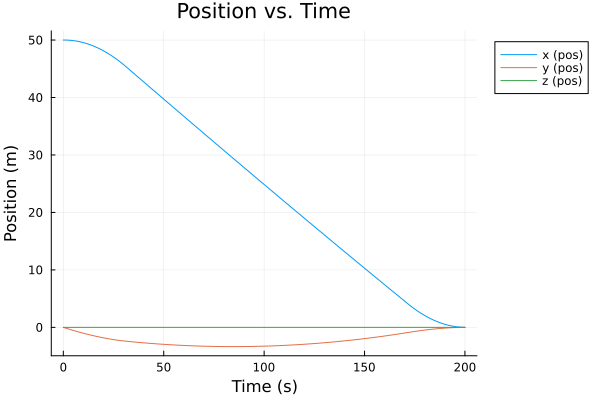

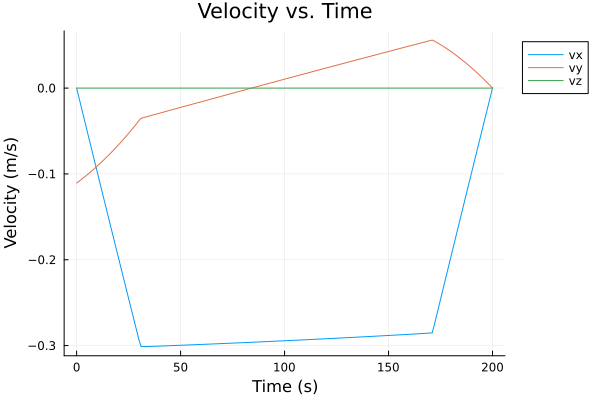

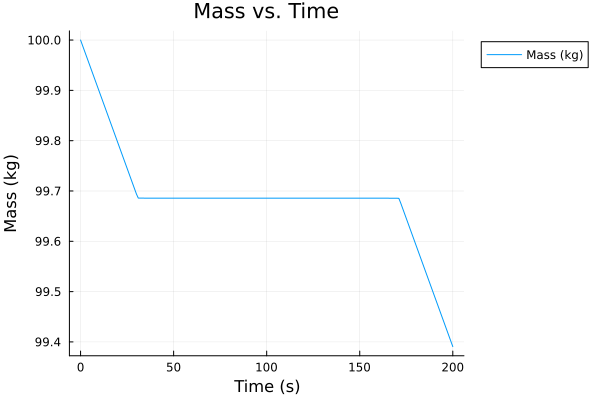

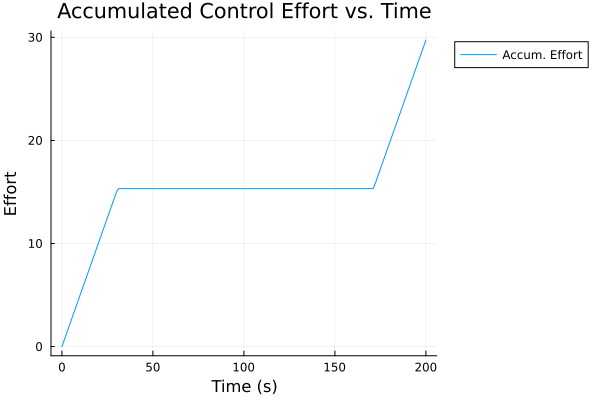

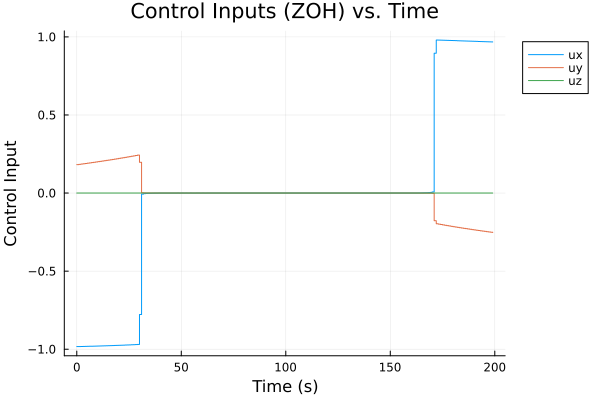

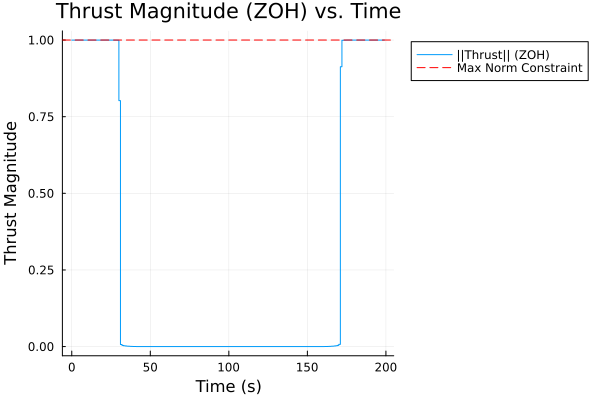

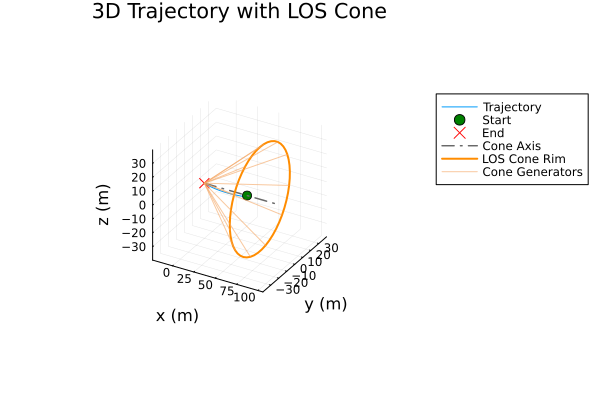

Final mass: 99.98345062522417
Generating plots...
Plotting complete. Check your Julia Plots pane or default plot window.


In [93]:
using Plots

X_solution = nothing
U_solution = nothing
if primal_status(model) == FEASIBLE_POINT || primal_status(model) == LOCALLY_SOLVED
    X_solution = value.(X_vars)
    U_solution = value.(U_vars)
    println("Final mass: ", X_sol[7, end])
end

if X_solution !== nothing && U_solution !== nothing
    println("Generating plots...")

    time_horizon = horizon * timestep

    # Create time vectors
    t_states = 0:timestep:time_horizon # For X_solution (horizon + 1 points)
    t_controls = 0:timestep:(time_horizon - timestep) # For U_solution (horizon points)

    # Extract individual state and control trajectories
    x_pos = X_solution[1, :]
    y_pos = X_solution[2, :]
    z_pos = X_solution[3, :]
    vx = X_solution[4, :]
    vy = X_solution[5, :]
    vz = X_solution[6, :]
    mass = X_solution[7, :]
    acc_effort = X_solution[8, :]

    ux = U_solution[1, :]
    uy = U_solution[2, :]
    uz = U_solution[3, :]

    # Calculate thrust magnitude
    thrust_magnitude = [sqrt(ux[t]^2 + uy[t]^2 + uz[t]^2) for t in 1:horizon]

    # --- Generate Plots ---

    # 1. Position Trajectories
    plot_positions = plot(t_states, x_pos, label="x (pos)", xlabel="Time (s)", ylabel="Position (m)", legend=:outertopright, title="Position vs. Time")
    plot!(plot_positions, t_states, y_pos, label="y (pos)")
    plot!(plot_positions, t_states, z_pos, label="z (pos)")

    # 2. Velocity Trajectories
    plot_velocities = plot(t_states, vx, label="vx", xlabel="Time (s)", ylabel="Velocity (m/s)", legend=:outertopright, title="Velocity vs. Time")
    plot!(plot_velocities, t_states, vy, label="vy")
    plot!(plot_velocities, t_states, vz, label="vz")

    # 3. Mass Trajectory
    plot_mass = plot(t_states, mass, label="Mass (kg)", xlabel="Time (s)", ylabel="Mass (kg)", legend=:outertopright, title="Mass vs. Time")

    # 4. Accumulated Control Effort
    plot_acc_effort = plot(t_states, acc_effort, label="Accum. Effort", xlabel="Time (s)", ylabel="Effort", legend=:outertopright, title="Accumulated Control Effort vs. Time")

    # 5. Control Inputs (Zeroth-Order Hold)
    plot_controls = plot(t_controls, ux, seriestype=:steppost, label="ux", xlabel="Time (s)", ylabel="Control Input", legend=:outertopright, title="Control Inputs (ZOH) vs. Time")
    plot!(plot_controls, t_controls, uy, seriestype=:steppost, label="uy")
    plot!(plot_controls, t_controls, uz, seriestype=:steppost, label="uz")

    # 6. Thrust Magnitude (Zeroth-Order Hold)
    plot_thrust_mag = plot(t_controls, thrust_magnitude, seriestype=:steppost, label="||Thrust|| (ZOH)", xlabel="Time (s)", ylabel="Thrust Magnitude", legend=:outertopright, title="Thrust Magnitude (ZOH) vs. Time")
    # Add norm constraint lines
    hline!(plot_thrust_mag, [u_max_norm_val], linestyle=:dash, color=:red, label="Max Norm Constraint")
    if u_min_norm_val > 0 # Only plot min norm if it's greater than 0
        hline!(plot_thrust_mag, [u_min_norm_val], linestyle=:dash, color=:orange, label="Min Norm Constraint")
    end


    # --- 7. 3D Trajectory with LOS Cone Visualization ---
    plot_3d_traj = plot(x_pos, y_pos, z_pos, label="Trajectory", xlabel="x (m)", ylabel="y (m)", zlabel="z (m)", title="3D Trajectory with LOS Cone", legend=:outertopright, aspect_ratio=:equal)
    scatter!(plot_3d_traj, [x_pos[1]], [y_pos[1]], [z_pos[1]], label="Start", markershape=:circle, markercolor=:green, markersize=5)
    scatter!(plot_3d_traj, [x_pos[end]], [y_pos[end]], [z_pos[end]], label="End", markershape=:xcross, markercolor=:red, markersize=5)

    # Define a suitable length for visualizing the cone (e.g., based on trajectory extent or nominal_radius)
    # Ensure nominal_radius is defined. If not, use a fixed value or calculate from trajectory.
    if @isdefined(nominal_radius)
         cone_vis_slant_length = nominal_radius * 1.5
    else
         cone_vis_slant_length = (isnothing(X_solution) ? 50.0 : maximum(sqrt.(X_solution[1,:].^2 + X_solution[2,:].^2 + X_solution[3,:].^2))) * 0.8
         if cone_vis_slant_length < 1.0; cone_vis_slant_length = 50.0; end # Default if trajectory is tiny
         println("nominal_radius not defined for cone viz, using scaled length: $cone_vis_slant_length")
    end


    # a. Plot Cone Axis
    # The axis extends from origin along cone_axis_param.
    # Length of plotted axis segment:
    axis_plot_length = cone_vis_slant_length * 1.1 # Make it slightly longer than cone slant for visibility
    axis_end_pt = axis_plot_length * cone_axis
    plot!(plot_3d_traj, [0, axis_end_pt[1]], [0, axis_end_pt[2]], [0, axis_end_pt[3]],
          linecolor=:dimgray, linestyle=:dashdot, label="Cone Axis", linewidth=1.5)

    # b. Plot Cone Rim (Circle)
    num_circle_points = 50
    phi_angles = range(0, 2*pi, length=num_circle_points)

    # The center of the base circle is along the cone axis
    circle_center_dist = cone_vis_slant_length * cos(max_cone_angle_rad)
    circle_center_pt = circle_center_dist * cone_axis
    # The radius of this base circle
    base_radius = cone_vis_slant_length * sin(max_cone_angle_rad)

    # To draw the circle, we need two orthogonal vectors (u1_vec, u2_vec) in the plane
    # perpendicular to cone_axis_param.
    temp_vec = abs(cone_axis[1]) < 0.9 ? [1.0, 0.0, 0.0] : [0.0, 1.0, 0.0] # A vector not parallel to cone_axis
    if norm(cross(cone_axis, temp_vec)) < 1e-6 # Handles if temp_vec is parallel
        temp_vec = abs(cone_axis_param[2]) < 0.9 ? [0.0, 1.0, 0.0] : [0.0, 0.0, 1.0]
    end
    u1_vec = cross(cone_axis, temp_vec)
    u1_vec = u1_vec / norm(u1_vec) # Normalize
    u2_vec = cross(cone_axis, u1_vec) # Already normalized

    circle_pts_x = zeros(num_circle_points)
    circle_pts_y = zeros(num_circle_points)
    circle_pts_z = zeros(num_circle_points)

    for i in 1:num_circle_points
        phi = phi_angles[i]
        # Point on the unit circle in the u1_vec, u2_vec plane, then scale by radius and shift by center
        pt_on_circle = circle_center_pt + base_radius * (cos(phi) * u1_vec + sin(phi) * u2_vec)
        circle_pts_x[i] = pt_on_circle[1]
        circle_pts_y[i] = pt_on_circle[2]
        circle_pts_z[i] = pt_on_circle[3]
    end
    plot!(plot_3d_traj, circle_pts_x, circle_pts_y, circle_pts_z,
          linecolor=:darkorange, label="LOS Cone Rim", linewidth=2)

    num_generator_lines = 12
    for k in 1:num_generator_lines
        # Pick points from the already calculated circle_pts arrays
        idx = Int(floor(1 + (k-1)*(num_circle_points-1)/(num_generator_lines-1+1e-9))) # Distribute points along the circle
        idx = min(max(1, idx), num_circle_points) # Ensure valid index

        plot!(plot_3d_traj, [0, circle_pts_x[idx]], [0, circle_pts_y[idx]], [0, circle_pts_z[idx]],
              linecolor=:sandybrown, alpha=0.6, label= k==1 ? "Cone Generators" : "", linewidth=1)
    end

    display(plot_positions)
    display(plot_velocities)
    display(plot_mass)
    display(plot_acc_effort)
    display(plot_controls)
    display(plot_thrust_mag)
    display(plot_3d_traj)

    println("Plotting complete. Check your Julia Plots pane or default plot window.")

else
    println("Solver did not find a solution, or solution variables are not available. Skipping plots.")
end